In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
path='/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
plt.figure(figsize=(70,70))
count=0
plant_names=[]
total_images=0
for i in os.listdir(path):
  count+=1
  plant_names.append(i)
  plt.subplot(7,7,count)

  images_path=os.listdir(path+"/"+i)
  print("Number of images of "+i+":",len(images_path),"||",end=" ")
  total_images+=len(images_path)

  image_show=plt.imread(path+"/"+i+"/"+images_path[0])
  
  plt.imshow(image_show)
  plt.xlabel(i)
  
  plt.xticks([])
  plt.yticks([])


print("Total number of images we have",total_images)


Number of images of Tomato___Late_blight: 1851 || Number of images of Tomato___healthy: 1926 || Number of images of Grape___healthy: 1692 || Number of images of Orange___Haunglongbing_(Citrus_greening): 2010 || Number of images of Soybean___healthy: 2022 || Number of images of Squash___Powdery_mildew: 1736 || Number of images of Potato___healthy: 1824 || Number of images of Corn_(maize)___Northern_Leaf_Blight: 1908 || Number of images of Tomato___Early_blight: 1920 || Number of images of Tomato___Septoria_leaf_spot: 1745 || Number of images of Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1642 || Number of images of Strawberry___Leaf_scorch: 1774 || Number of images of Peach___healthy: 1728 || Number of images of Apple___Apple_scab: 2016 || Number of images of Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1961 || Number of images of Tomato___Bacterial_spot: 1702 || Number of images of Apple___Black_rot: 1987 || Number of images of Blueberry___healthy: 1816 || Number of images of Cherry

In [5]:
print(plant_names)
print(len(plant_names))

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [6]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau


2024-02-17 20:05:02.086303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 20:05:02.086404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 20:05:02.241890: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [8]:
base_model_tf=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=38)


94765736/94765736 [==============================] - 1s 0us/step


In [9]:
#Model building
base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) #This function used to zero-center each color channel wrt Imagenet dataset
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=Dense(38,activation='softmax')(model_resnet)


model_main=Model(inputs=pt,outputs=model_resnet)
model_main.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [10]:
#Image augmentation
train_datagen= ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False
                                  ,fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2)

val_datagen=ImageDataGenerator()

path_train='/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'

path_valid='/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

train= train_datagen.flow_from_directory(directory=path_train,batch_size=32,target_size=(224,224),
                                         color_mode='rgb',class_mode='categorical',seed=42)

valid=val_datagen.flow_from_directory(directory=path_valid,batch_size=32,target_size=(224,224),color_mode='rgb',class_mode='categorical')



Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [11]:
#CallBacks
es=EarlyStopping(monitor='val_accuracy',verbose=1,patience=7,mode='auto')
mc=ModelCheckpoint(filepath='/content',monitor='val_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=5,min_lr=0.001)

In [12]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
#Training
model_main.fit(train,validation_data=valid,epochs=5,steps_per_epoch=200,verbose=1,callbacks=[mc,es,lr])

Epoch 1/5


I0000 00:00:1708200508.555746     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - ETA: 0s - loss: 1.3376 - accuracy: 0.6405
Epoch 1: val_accuracy improved from -inf to 0.84720, saving model to /content
200/200 [==============================] - 233s 1s/step - loss: 1.3376 - accuracy: 0.6405 - val_loss: 0.5372 - val_accuracy: 0.8472 - lr: 0.0010
Epoch 2/5
200/200 [==============================] - ETA: 0s - loss: 0.4370 - accuracy: 0.8716
Epoch 2: val_accuracy improved from 0.84720 to 0.89472, saving model to /content
200/200 [==============================] - 174s 869ms/step - loss: 0.4370 - accuracy: 0.8716 - val_loss: 0.3349 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 3/5
200/200 [==============================] - ETA: 0s - loss: 0.3323 - accuracy: 0.8933
Epoch 3: val_accuracy improved from 0.89472 to 0.91908, saving model to /content
200/200 [==============================] - 182s 911ms/step - loss: 0.3323 - accuracy: 0.8933 - val_loss: 0.2468 - val_accuracy: 0.9191 - lr: 0.0010
Epoch 4/5
200/200 [=========================

In [14]:
model_main.save("RESNET50_PLANT_DISEASE.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image

Text(0.5, 1.0, 'loss')

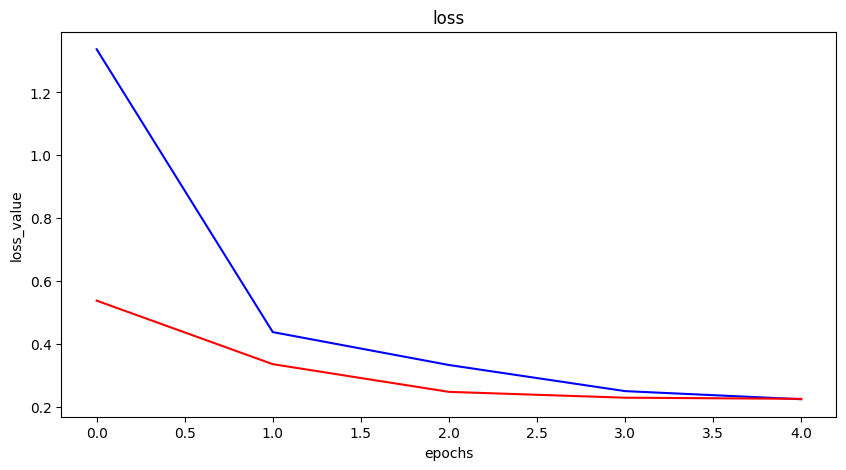

In [16]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'],color='b',label='Training loss')
plt.plot(model_main.history.history['val_loss'],color='r',label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss_value")
plt.title("loss")


Text(0.5, 1.0, 'accuracy graph')

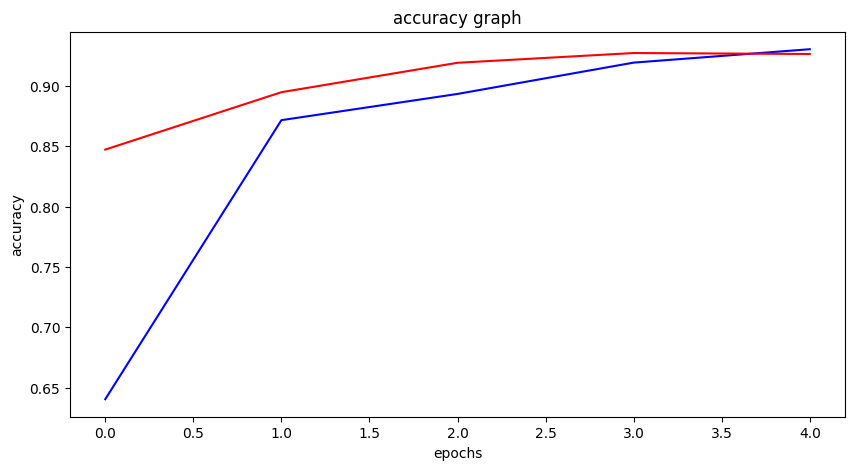

In [17]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(model_main.history.history['val_accuracy'],color='r',label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy graph")